# NN Experiments with different methods

- SVRG vs L-SVRG
- SARAH vs PAGE


In [818]:
import time
import warnings
from typing import Callable, Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.utils.data
from cycler import cycler
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [819]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [820]:
MANUAL_SEED = 42
np.random.seed(MANUAL_SEED)

## Data loading


In [821]:
def load_MNIST_binary() -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    df = pd.read_csv("../data/interim/mnist_binary.csv", index_col=None)

    y, X = df.iloc[:, 0].to_numpy(), df.iloc[:, 1:].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42
    )

    return X_train, y_train, X_test, y_test


def load_MNIST() -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    df = pd.read_csv("../data/raw/mnist.csv", index_col=None)

    y, X = df.iloc[:, 0].to_numpy(), df.iloc[:, 1:].to_numpy()
    X = X / 255

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42
    )

    return X_train, y_train, X_test, y_test


def load_mushrooms() -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    data = load_svmlight_file("../data/raw/mushrooms.txt")
    X, y = data[0].toarray(), data[1]
    y = 2 * y - 3

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return X_train, y_train, X_test, y_test


def load_dataset(
    dataset: Literal["MNIST_binary"] | Literal["mushrooms"] | Literal["MNIST"],
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    if dataset == "MNIST_binary":
        return load_MNIST_binary()
    if dataset == "MNIST":
        return load_MNIST()
    return load_mushrooms()

In [822]:
X_train, Y_train, X_test, Y_test = load_dataset("MNIST_binary")

In [823]:
print(f"{X_train.shape=}, {Y_train.shape=}")
print(f"{X_test.shape=}, {Y_test.shape=}")

X_train.shape=(1800, 784), Y_train.shape=(1800,)
X_test.shape=(200, 784), Y_test.shape=(200,)


In [824]:
DATA_SIZE = Y_train.shape[0]
NUM_LABELS = len(np.unique(Y_train))

In [825]:
def labels_to_vectors(labels: np.ndarray, map_dict: Optional[dict] = None) -> np.ndarray:
    vectorized = []
    local_map_dict = (
        map_dict
        if map_dict is not None
        else {label: i for i, label in enumerate(np.unique(labels))}
    )
    for label in labels:
        zeroes = np.zeros(NUM_LABELS)
        zeroes[local_map_dict[label]] = 1.0
        vectorized.append(zeroes)
    return np.array(vectorized)

In [826]:
train_values = torch.tensor(X_train).float()
train_targets = torch.tensor(labels_to_vectors(Y_train)).float()
test_values = torch.tensor(X_test).float()
test_targets = torch.tensor(labels_to_vectors(Y_test)).float()

## Problems


In [827]:
class Problem:
    def reset(self):
        raise NotImplementedError

    def compute_gradient(self, data_indices: Optional[np.ndarray] = None) -> float:
        raise NotImplementedError

    def predict(self, x_values: torch.Tensor) -> np.ndarray:
        raise NotImplementedError

    def get_batch_indices(self, batch_size: int) -> np.ndarray:
        raise NotImplementedError

    def set_params(self, params: list[np.ndarray]):
        raise NotImplementedError

    def iterate_params_grad(self) -> list[tuple[np.ndarray, np.ndarray]]:
        raise NotImplementedError

    def iterate_params(self) -> list[np.ndarray]:
        raise NotImplementedError

    def get_data_size(self) -> int:
        raise NotImplementedError

    def zero_grads(self):
        raise NotImplementedError

### Basic Logistic Regression


### Code


In [828]:
class BasicLogisticRegression(Problem):
    def _to_tensor(self, x: np.ndarray) -> torch.Tensor:
        return torch.tensor(x).float().to(self.device)

    def _to_numpy(self, x: torch.Tensor) -> np.ndarray:
        return x.cpu().detach().numpy()

    def _get_data(
        self, data_indices: Optional[np.ndarray] = None
    ) -> tuple[torch.Tensor, torch.Tensor]:
        if data_indices is None:
            return self.data

        return (self.data[0][data_indices], self.data[1][data_indices])

    def _get_result(self, x: torch.Tensor) -> torch.Tensor:
        return F.softmax(F.relu(x @ self.params["W"] + self.params["B"]))

    def _get_loss(self, res: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        return F.cross_entropy(res, targets)

    def _get_value(self, data_indices: Optional[np.ndarray] = None) -> torch.Tensor:
        data = self._get_data(data_indices)
        for p in self.params.values():
            p.requires_grad_()

        x = data[0].to(self.device)
        y = data[1].to(self.device)

        res = self._get_result(x)

        return self._get_loss(res, y)

    def __init__(
        self,
        data: tuple[torch.Tensor, torch.Tensor],
        seed: float = MANUAL_SEED,
        device: torch.device = DEVICE,
    ) -> None:
        self.device = device
        self.data = data
        self.seed = seed

        self.data_size: int = data[0].shape[0]
        self.possible_indices = list(range(self.data_size))
        self.input_dim = self.data[0].shape[1]
        self.output_dim = NUM_LABELS

        self.reset()

    def reset(self):
        np.random.seed(self.seed)

        self.params: dict[str, torch.Tensor] = {
            "W": self._to_tensor(np.random.rand(self.input_dim, self.output_dim)),
            "B": self._to_tensor(np.random.rand(self.output_dim)),
        }
        self.param_names = list(self.params.keys())

    def compute_gradient(self, data_indices: Optional[np.ndarray] = None) -> float:
        loss = self._get_value(data_indices)
        loss.backward(retain_graph=True)
        return loss.item()

    def predict(self, x_values: torch.Tensor) -> np.ndarray:
        res = self._get_result(self._to_tensor(x_values))
        return np.argmax(self._to_numpy(res), axis=1)

    def get_batch_indices(self, batch_size: int) -> np.ndarray:
        return np.random.choice(self.possible_indices, batch_size, replace=False)  # type: ignore

    def set_params(self, params: list[np.ndarray]):
        for name, new_param in zip(self.param_names, params):
            self.params[name] = self._to_tensor(new_param)

    def iterate_params_grad(self) -> list[tuple[np.ndarray, np.ndarray]]:
        params = []
        for name in self.param_names:
            p = self.params[name]
            grad = p.grad
            params.append((self._to_numpy(p), self._to_numpy(grad)))
        return params

    def iterate_params(self) -> list[np.ndarray]:
        params = []
        for name in self.param_names:
            p = self.params[name].clone()
            params.append(self._to_numpy(p))
        return params

    def get_data_size(self) -> int:
        return self.data_size

    def zero_grads(self):
        for name in self.param_names:
            self.params[name] = self.params[name].detach()

In [829]:
blr_ = BasicLogisticRegression((train_values, train_targets))

print(f"{blr_.compute_gradient()=}")

blr_.compute_gradient()=0.8436364531517029


## Methods


Maximum iterations: 1000

Required precision $\varepsilon  =10^{-5}$

$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$ is used as default convergence criterion.


In [830]:
NUM_ITERATIONS = 1000
NUM_ITERATIONS = 100
EPSILON = 1e-5

np.random.seed(420)
START_POINT = np.random.randn(X_train.shape[1], NUM_LABELS)

In [831]:
class Method:
    def update(self, f: Problem, iteration: int) -> int:
        raise NotImplementedError

In [832]:
IterationType = Literal["iterations"] | Literal["gradients"] | Literal["time"]


class Checker:
    def _get_accuracy(self) -> float:
        predictions = self.f.predict(self.test_values)
        return (predictions == self.test_labels).sum() / self.test_labels.shape[0]

    def __init__(
        self,
        name: str,
        f: Problem,
        optimizer: Method,
        test_data: tuple[torch.Tensor, torch.Tensor],
        verbose: bool = True,
    ) -> None:
        self.name = name
        self.f = f
        self.optimizer = optimizer
        self.test_values = test_data[0]
        self.verbose = verbose

        self.test_labels = torch.argmax(test_data[1], axis=1).cpu().numpy()

        self.get_iterations_check: dict[IterationType, Callable[[], float]] = {
            "iterations": lambda: self.total_pass_iterations,
            "gradients": lambda: self.total_used_gradients,
            "time": lambda: self.total_passed_time,
        }

        self.get_iterations_update: dict[IterationType, Callable[[int, float], float]] = {
            "iterations": lambda gradients, passed_time: 1,
            "gradients": lambda gradients, passed_time: gradients,
            "time": lambda gradients, passed_time: passed_time,
        }

        self.reset()

    def calculate_loss(self) -> float:
        loss = self.f.compute_gradient()
        self.f.zero_grads()
        return loss

    def predict(self, x_values: np.ndarray) -> np.ndarray:
        return self.f.predict(x_values)

    def get_name(self) -> str:
        return self.name

    def get_pass_iterations_logs(self) -> list[int]:
        return list(range(self.total_pass_iterations + 1))

    def get_used_gradients_logs(self) -> list[int]:
        return self.used_gradients_logs

    def get_time_logs(self) -> list[float]:
        return self.time_logs

    def get_accuracy_logs(self) -> list[float]:
        return self.accuracy_logs

    def get_loss_logs(self) -> list[float]:
        return self.loss_logs

    def reset(self):
        self.loss_logs = []
        self.time_logs = []
        self.accuracy_logs = []
        self.used_gradients_logs = []

        self.used_gradients = 0
        self.passed_time = 0

        self.total_used_gradients = 0
        self.total_pass_iterations = 0
        self.total_passed_time = 0

    def start(
        self,
        max_iterations: float = NUM_ITERATIONS,
        iteration_type: IterationType = "iterations",
        early_stop_accuracy: float = 0.99,
    ):
        self.reset()

        if self.verbose:
            progress_bar = tqdm(
                total=max_iterations, desc=self.name, leave=True, position=0
            )

        iterations_check = self.get_iterations_check[iteration_type]
        iterations_update = self.get_iterations_update[iteration_type]

        # logging
        self.time_logs.append(self.total_passed_time)
        self.loss_logs.append(self.calculate_loss())
        self.used_gradients_logs.append(self.total_used_gradients)
        self.accuracy_logs.append(self._get_accuracy())

        while iterations_check() < max_iterations:
            k = self.total_pass_iterations

            start_time = time.time()
            used_gradients = self.optimizer.update(self.f, k)
            finish_time = time.time()
            elapsed_time = finish_time - start_time
            loss = self.calculate_loss()

            self.total_pass_iterations += 1
            self.total_passed_time += elapsed_time
            self.total_used_gradients += used_gradients

            # logging
            accuracy = self._get_accuracy()
            self.time_logs.append(self.total_passed_time)
            self.loss_logs.append(loss)
            self.used_gradients_logs.append(self.total_used_gradients)
            self.accuracy_logs.append(accuracy)

            if self.verbose:
                info_dict = {"time": self.passed_time, "loss": loss, "accuracy": accuracy}
                progress_bar.set_postfix(info_dict)  # type: ignore
                progress_bar.update(iterations_update(used_gradients, elapsed_time))  # type: ignore

            if np.isnan(loss):  # diverges
                break

            if accuracy >= early_stop_accuracy:
                break

        if self.verbose:
            progress_bar.close()  # type: ignore

### SGD

In [833]:
class SGD(Method):
    def __init__(
        self,
        step_size: Callable[[int], float],
        batch_size: int,
    ) -> None:
        self.step_size = step_size
        self.batch_size = batch_size

    def update(self, f: Problem, iteration: int) -> int:
        learning_rate = self.step_size(iteration)

        batch_indices = f.get_batch_indices(self.batch_size)
        f.compute_gradient(batch_indices)

        new_params = []
        for p, grad_p in f.iterate_params_grad():
            new_p = p - learning_rate * grad_p
            new_params.append(new_p.copy())
        f.zero_grads()
        f.set_params(new_params)

        return self.batch_size

### SVRG


In [834]:
class SVRG(Method):
    def __init__(
        self,
        step_size: Callable[[int], float],
        epoch_length: int,
        batch_size: int,
    ) -> None:
        self.step_size = step_size
        self.epoch_length = epoch_length
        self.batch_size = batch_size

    def update(self, f: Problem, iteration: int) -> int:
        learning_rate = self.step_size(iteration)

        tilde_params = f.iterate_params()
        f.compute_gradient()
        full_grads = [g for (_, g) in f.iterate_params_grad()]
        f.zero_grads()

        inside_params = tilde_params.copy()
        aggregated_params = tilde_params.copy()

        for _ in range(self.epoch_length):
            batch_indices = f.get_batch_indices(self.batch_size)

            f.set_params(inside_params)
            f.compute_gradient(batch_indices)
            inside_grads = [g for (_, g) in f.iterate_params_grad()]
            f.zero_grads()

            f.set_params(tilde_params)
            f.compute_gradient(batch_indices)
            tilde_grads = [g for (_, g) in f.iterate_params_grad()]
            f.zero_grads()

            for p_idx in range(len(tilde_grads)):
                g_k = inside_grads[p_idx] - tilde_grads[p_idx] + full_grads[p_idx]
                inside_params[p_idx] = inside_params[p_idx] - learning_rate * g_k
                aggregated_params[p_idx] += inside_params[p_idx]

        final_params = [
            aggregated_p / self.epoch_length for aggregated_p in aggregated_params
        ]
        f.set_params(final_params)

        return f.get_data_size() + 2 * self.epoch_length * self.batch_size

In [835]:
# s = 20
# f = BasicLogisticRegression((train_values, train_targets))
# sgd = SVRG(lambda _: 1e-1,  s, DATA_SIZE//s )
# checker = Checker("SVRG", f, sgd, (test_values, test_targets))

# checker.start(max_iterations=1e6, iteration_type="gradients")

In [836]:
# draw_method_plots(
#     [checker],
#     plots=[("used_gradients", "criterion"), ("used_gradients", "accuracy")],
#     title="SVRG",
# )

### L-SVRG


In [837]:
class LSVRG(Method):
    def __init__(
        self,
        step_size: Callable[[int], float],
        probability: float,
        batch_size: int,
    ) -> None:
        self.step_size = step_size
        self.batch_size = batch_size
        self.probability = probability

        self.has_params_tilde: bool = False
        self.params_tilde: list[np.ndarray] = [np.zeros(2)]
        self.full_grads_tilde: list[np.ndarray] = [np.zeros(2)]

    def update(self, f: Problem, iteration: int) -> int:
        learning_rate = self.step_size(iteration)

        if not self.has_params_tilde:
            self.has_params_tilde = True
            f.compute_gradient()
            self.params_tilde, self.full_grads_tilde = zip(*f.iterate_params_grad())
            f.zero_grads()

        initial_params = f.iterate_params()
        batch_indices = f.get_batch_indices(self.batch_size)

        f.compute_gradient(batch_indices)
        grads = [g for (_, g) in f.iterate_params_grad()]
        f.zero_grads()

        f.set_params(self.params_tilde)
        f.compute_gradient(batch_indices)
        grads_tilde = [g for (_, g) in f.iterate_params_grad()]
        f.zero_grads()

        total_grads = [
            g - g_tilde + full_grads_tilde
            for (g, g_tilde, full_grads_tilde) in zip(
                grads, grads_tilde, self.full_grads_tilde
            )
        ]

        final_params = [
            init_p - learning_rate * g for (init_p, g) in zip(initial_params, total_grads)
        ]

        used_gradients = 2 * self.batch_size

        if np.random.random() < self.probability:
            f.set_params(initial_params)
            f.compute_gradient()
            self.params_tilde, self.full_grads_tilde = zip(*f.iterate_params_grad())
            f.zero_grads()

            used_gradients += f.get_data_size()

        f.set_params(final_params)

        return used_gradients

In [838]:
# s = 200
# s=1000

# f = BasicLogisticRegression((train_values, train_targets))
# # sgd = LSVRG(lambda _: 1e-1,  DATA_SIZE//s, 1/s)
# sgd = LSVRG(lambda _: 1e-2,  DATA_SIZE//s, 1/s)
# checker = Checker("L-SVRG", f, sgd, (test_values, test_targets))

# checker.start(max_iterations=1e7, iteration_type="gradients")
# # checker.start(max_iterations=1000)

In [839]:
# draw_method_plots(
#     [checker],
#     plots=[("used_gradients", "criterion"), ("used_gradients", "accuracy")],
#     title="L-SVRG",
# )

#### SARAH


In [840]:
class SARAH(Method):
    def __init__(
        self,
        step_size: Callable[[int], float],
        epoch_length: int,
        batch_size: int,
    ) -> None:
        self.step_size = step_size
        self.epoch_length = epoch_length
        self.batch_size = batch_size

    def update(self, f: Problem, iteration: int) -> int:
        learning_rate = self.step_size(iteration)

        initial_params = f.iterate_params()
        param_list = [initial_params.copy()]

        f.compute_gradient()
        vs = [g for (_, g) in f.iterate_params_grad()]
        f.zero_grads()

        param_list.append([p - learning_rate * v for (p, v) in zip(param_list[0], vs)])

        stop_idx = np.random.randint(self.epoch_length)

        for _ in range(stop_idx - 1):
            batch_indices = f.get_batch_indices(self.batch_size)

            f.set_params(param_list[-1])
            f.compute_gradient(batch_indices)
            prev_grads = [g for (_, g) in f.iterate_params_grad()]
            f.zero_grads()

            f.set_params(param_list[-2])
            f.compute_gradient(batch_indices)
            prev_prev_grads = [g for (_, g) in f.iterate_params_grad()]
            f.zero_grads()

            vs = [
                p_g - pp_g + v for (p_g, pp_g, v) in zip(prev_grads, prev_prev_grads, vs)
            ]

            param_list.append(
                [p - learning_rate * v for (p, v) in zip(param_list[-1], vs)]
            )

        f.set_params(param_list[stop_idx])

        return f.get_data_size() + 2 * (stop_idx + 1) * self.batch_size

In [841]:
# # s = 10
# s = 100

# f = BasicLogisticRegression((train_values, train_targets))
# sgd = SARAH(lambda _: 0.5,  s, DATA_SIZE//s)
# checker = Checker("SARAH", f, sgd, (test_values, test_targets))

# checker.start(max_iterations=1e6, iteration_type="gradients")
# # checker.start(max_iterations=1000)

In [842]:
# draw_method_plots(
#     [checker],
#     plots=[("used_gradients", "criterion"), ("used_gradients", "accuracy")],
#     title="SARAH",
# )

### PAGE


In [843]:
class PAGE(Method):
    def __init__(
        self,
        step_size: Callable[[int], float],
        probability: float,
        primary_batch_size: int,
        secondary_batch_size: int,
    ) -> None:
        self.step_size = step_size
        self.probability = probability

        self.primary_batch_size = primary_batch_size
        self.secondary_batch_size = secondary_batch_size

        self.have_gs_computed: bool = False
        self.gs: list[np.ndarray] = [np.zeros(2)]

    def update(self, f: Problem, iteration: int) -> int:
        learning_rate = self.step_size(iteration)

        if not self.have_gs_computed:
            self.have_gs_computed = True
            batch_indices = f.get_batch_indices(self.primary_batch_size)
            f.compute_gradient(batch_indices)
            self.gs = [g for (_, g) in f.iterate_params_grad()]
            f.zero_grads()

        initial_params = f.iterate_params()
        next_params = [
            init_p - learning_rate * g for (init_p, g) in zip(initial_params, self.gs)
        ]
        f.set_params(next_params)

        if np.random.random() < self.probability:
            batch_indices = f.get_batch_indices(self.primary_batch_size)
            f.compute_gradient(batch_indices)
            self.gs = [g for (_, g) in f.iterate_params_grad()]
            f.zero_grads()

            return self.primary_batch_size

        batch_indices = f.get_batch_indices(self.secondary_batch_size)

        f.compute_gradient(batch_indices)
        current_grads = [g for (_, g) in f.iterate_params_grad()]
        f.zero_grads()

        f.set_params(initial_params)
        f.compute_gradient(batch_indices)
        prev_grads = [g for (_, g) in f.iterate_params_grad()]
        f.zero_grads()

        self.gs = [
            g + curr_g - prev_g
            for (g, curr_g, prev_g) in zip(self.gs, current_grads, prev_grads)
        ]

        return 2 * self.secondary_batch_size

In [844]:
# # primary_b = 100
# # secondary_b = 10
# primary_b = 100
# secondary_b = 50

# f = BasicLogisticRegression((train_values, train_targets))
# sgd = PAGE(lambda _: 1,  secondary_b/(primary_b+secondary_b), primary_b, secondary_b)
# checker = Checker("PAGE", f, sgd, (test_values, test_targets))

# checker.start(max_iterations=1e6, iteration_type="gradients")
# # checker.start(max_iterations=1000)

## Utilities


In [845]:
PREDEFINED_COLORS = [
    "#ffa500",
    "#c83cbc",
    "#1c1c84",
    "#ff0000",
    "#08a4a7",
    "#008000",
]


AxesValues = (
    Literal["criterion"]
    | Literal["accuracy"]
    | Literal["iterations"]
    | Literal["time"]
    | Literal["used_gradients"]
    | Literal["log_used_gradients"]
)
PREDEFINED_AXES_VALUES: dict[AxesValues, dict] = {
    "criterion": {
        "name": "Criterion",
        "label": "Criterion, log scale",
        "get_data": lambda m: m.get_loss_logs(),
        "log": True,
    },
    "accuracy": {
        "name": "Accuracy",
        "label": "Accuracy",
        "get_data": lambda m: m.get_accuracy_logs(),
        "log": False,
    },
    "iterations": {
        "name": "Iterations",
        "label": "Iterations",
        "get_data": lambda m: m.get_pass_iterations_logs(),
        "log": False,
    },
    "time": {
        "name": "Time",
        "label": "Running time, seconds",
        "get_data": lambda m: m.get_time_logs(),
        "log": False,
    },
    "used_gradients": {
        "name": "Used gradients",
        "label": "Used gradients",
        "get_data": lambda m: m.get_used_gradients_logs(),
        "log": False,
    },
    "log_used_gradients": {
        "name": "Used gradients",
        "label": "Used gradients, log scale",
        "get_data": lambda m: m.get_used_gradients_logs(),
        "log": True,
    },
}


PlotDescription = tuple[AxesValues, AxesValues]


def draw_method_plots(
    methods: list[Checker],
    title: str,
    plots: list[PlotDescription],
    ylim=None,
    plot_width: float = 16,
    plot_height: float = 7,
    use_rainbow: bool = False,
    use_common_legend: bool = True,
):
    num_plots = len(plots)
    if use_rainbow:
        num_colors = len(methods)
        cm = plt.get_cmap("gist_rainbow")
        colors = [cm(1.0 * i / num_colors) for i in range(num_colors)]
    else:
        colors = PREDEFINED_COLORS

    style_cycler = cycler(linestyle=["-", "--", ":", "-."]) * cycler(color=colors)

    fig, axs = plt.subplots(num_plots, 1, figsize=(plot_width, plot_height * num_plots))
    fig.suptitle(title, fontsize=14)
    axs_list = [axs] if num_plots == 1 else list(axs.flat)

    for ax in axs_list:
        ax.grid()
        ax.set_prop_cycle(style_cycler)
        if ylim is not None:
            ax.set_ylim(top=ylim)

    for ax, (p1, p2) in zip(axs_list, plots):
        p1_data = PREDEFINED_AXES_VALUES[p1]
        p2_data = PREDEFINED_AXES_VALUES[p2]

        ax.set_title(f"{p2_data['name']} over {p1_data['name']}")
        ax.set(xlabel=p1_data["label"], ylabel=p2_data["label"])

        if p1_data["log"]:
            ax.set_xscale("log")
        if p2_data["log"]:
            ax.set_yscale("log")

        for method in methods:
            label = method.name

            x_values = p1_data["get_data"](method)
            y_values = p2_data["get_data"](method)

            ax.plot(x_values, y_values, label=label)
            ax.scatter(x_values[-1], y_values[-1], s=15)

    if use_common_legend:
        lines_labels = [axs_list[0].get_legend_handles_labels()]
        lines, labels = [sum(x, []) for x in zip(*lines_labels)]
        fig.legend(
            lines,
            labels,
            scatterpoints=1,
            markerscale=3,
            loc="outside lower center",
            ncol=min(5, len(methods)),
            bbox_to_anchor=(0.5, -0.05),
        )
    else:
        if len(methods) > 1:
            for ax in axs_list:
                ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))

    plt.tight_layout()
    plt.subplots_adjust(
        top=1 - 0.1 / (num_plots**0.5), bottom=0.12 / (num_plots**2), hspace=0.15
    )

## Basic LR Experiments


### Ex1. SVRG vs L-SVRG


In [846]:
SVRG_LR_DICT: dict[str, Callable[[int], float]] = {
    "SVRG": lambda _: 1e-1,
    "LSVRG": lambda _: 1e-1,
}
SVRG_S = 100  # 20
SVRG_B = DATA_SIZE // SVRG_S
SVRG_P = 1 / SVRG_S


svrgs: list[Checker] = [
    Checker(
        "SVRG",
        BasicLogisticRegression((train_values, train_targets)),
        SVRG(SVRG_LR_DICT["SVRG"], SVRG_S, SVRG_B),
        (test_values, test_targets),
    ),
    Checker(
        "L-SVRG",
        BasicLogisticRegression((train_values, train_targets)),
        LSVRG(SVRG_LR_DICT["LSVRG"], SVRG_P, SVRG_B),
        (test_values, test_targets),
    ),
]

for svrg in svrgs:
    _ = svrg.start(max_iterations=1e5, iteration_type="gradients")

SVRG:  16%|█▌        | 16200/100000.0 [00:02<00:12, 6521.75it/s, time=0, loss=0.321, accuracy=0.995]
L-SVRG:   3%|▎         | 3312/100000.0 [00:00<00:24, 4019.41it/s, time=0, loss=0.368, accuracy=0.99] 


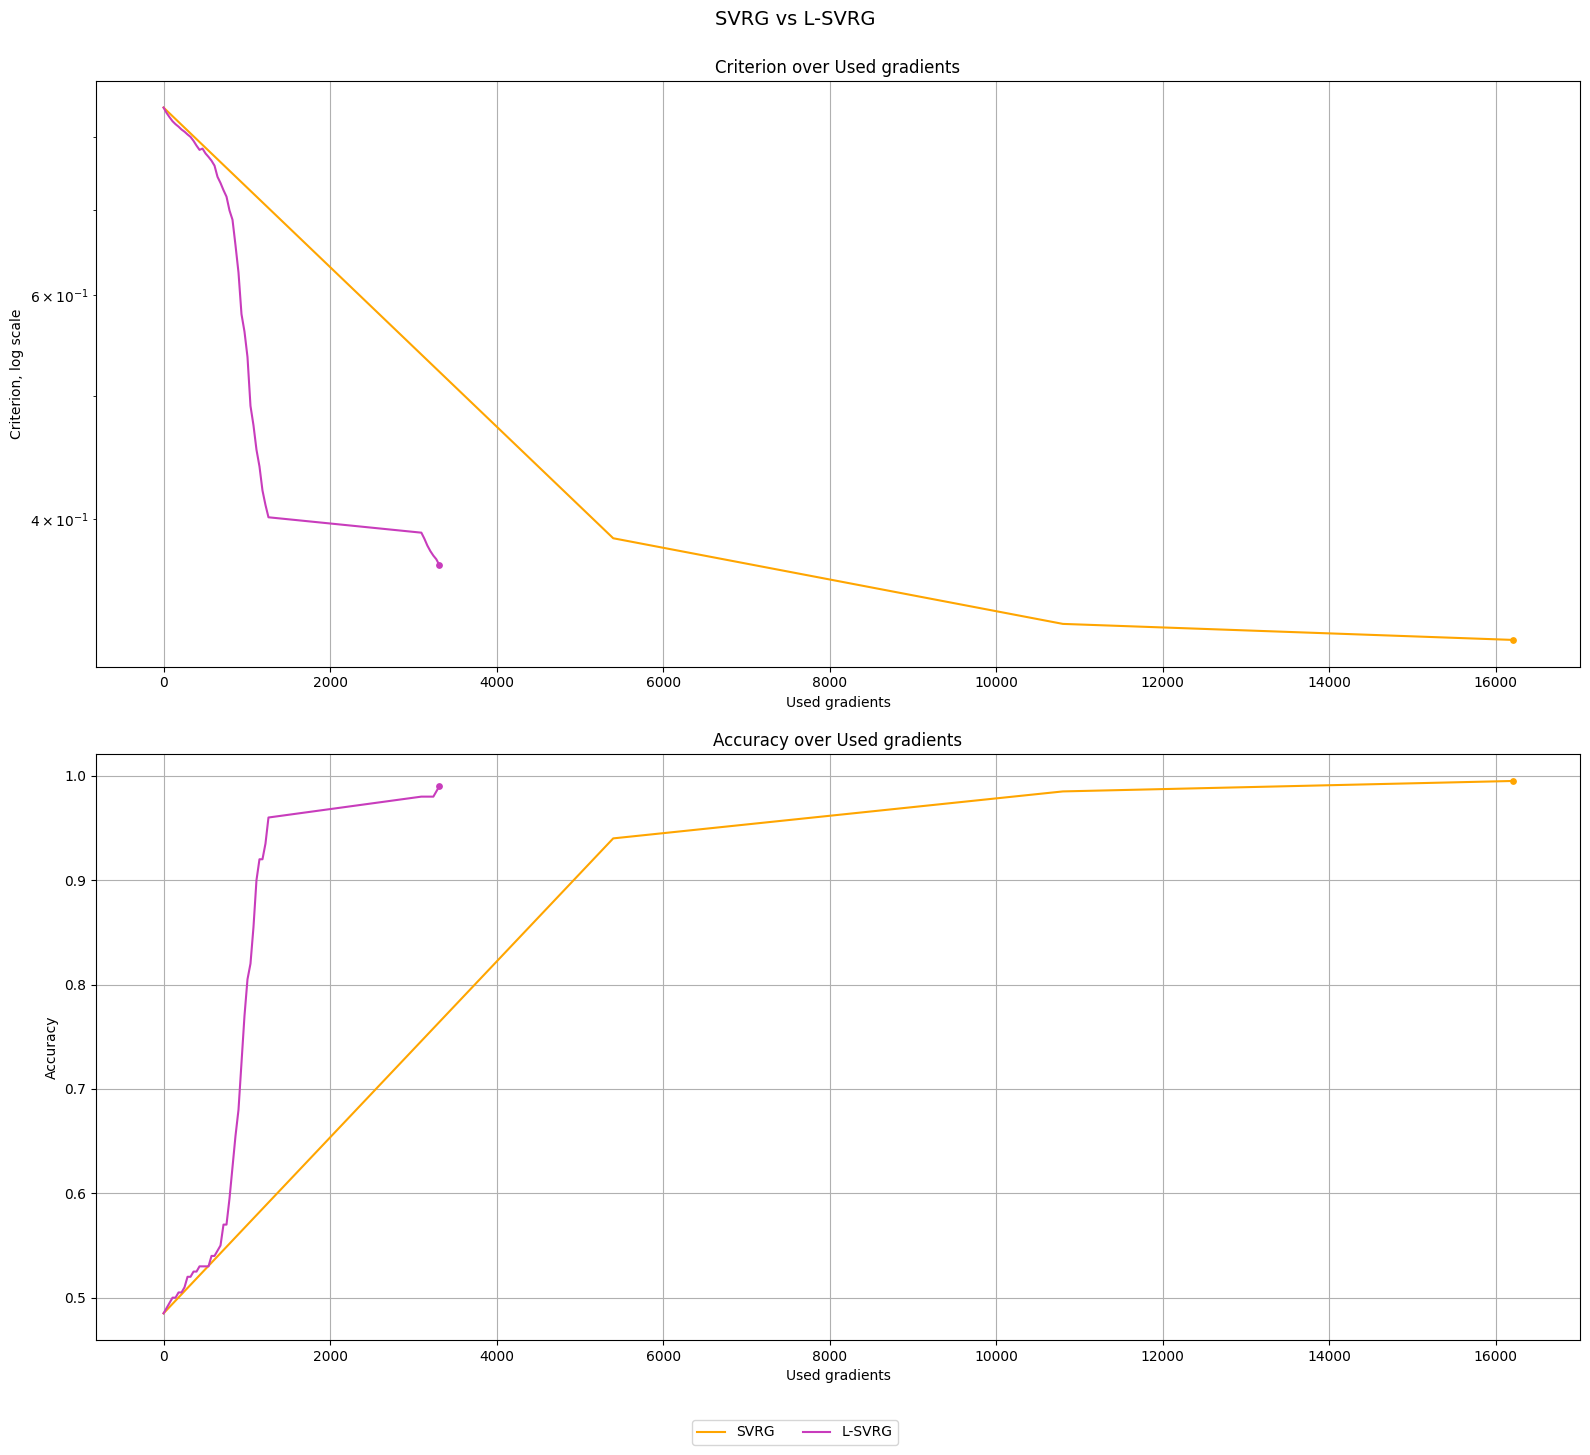

In [847]:
draw_method_plots(
    svrgs,
    plots=[("used_gradients", "criterion"), ("used_gradients", "accuracy")],
    title="SVRG vs L-SVRG",
)

### Ex2. SARAH vs PAGE


In [848]:
SARAH_LR_DICT: dict[str, Callable[[int], float]] = {
    "SARAH": lambda _: 1e-1,
    "PAGE": lambda _: 1e-1,
}

SARAH_B_SECONDARY = 10
SARAH_B_PRIMARY = SARAH_B_SECONDARY**2

SARAH_P = SARAH_B_SECONDARY / (SARAH_B_PRIMARY + SARAH_B_SECONDARY)


sarahs: list[Checker] = [
    Checker(
        "SARAH",
        BasicLogisticRegression((train_values, train_targets)),
        SARAH(SARAH_LR_DICT["SARAH"], DATA_SIZE // SARAH_B_PRIMARY, SARAH_B_PRIMARY),
        (test_values, test_targets),
    ),
    Checker(
        "PAGE",
        BasicLogisticRegression((train_values, train_targets)),
        PAGE(SARAH_LR_DICT["PAGE"], SARAH_P, SARAH_B_PRIMARY, SARAH_B_SECONDARY),
        (test_values, test_targets),
    ),
]


for sarah in sarahs:
    _ = sarah.start(max_iterations=1e5, iteration_type="gradients")

SARAH:  20%|█▉        | 19600/100000.0 [00:00<00:01, 51176.57it/s, time=0, loss=0.356, accuracy=0.995]
PAGE:   9%|▉         | 9280/100000.0 [00:06<00:59, 1533.54it/s, time=0, loss=0.371, accuracy=0.99] 


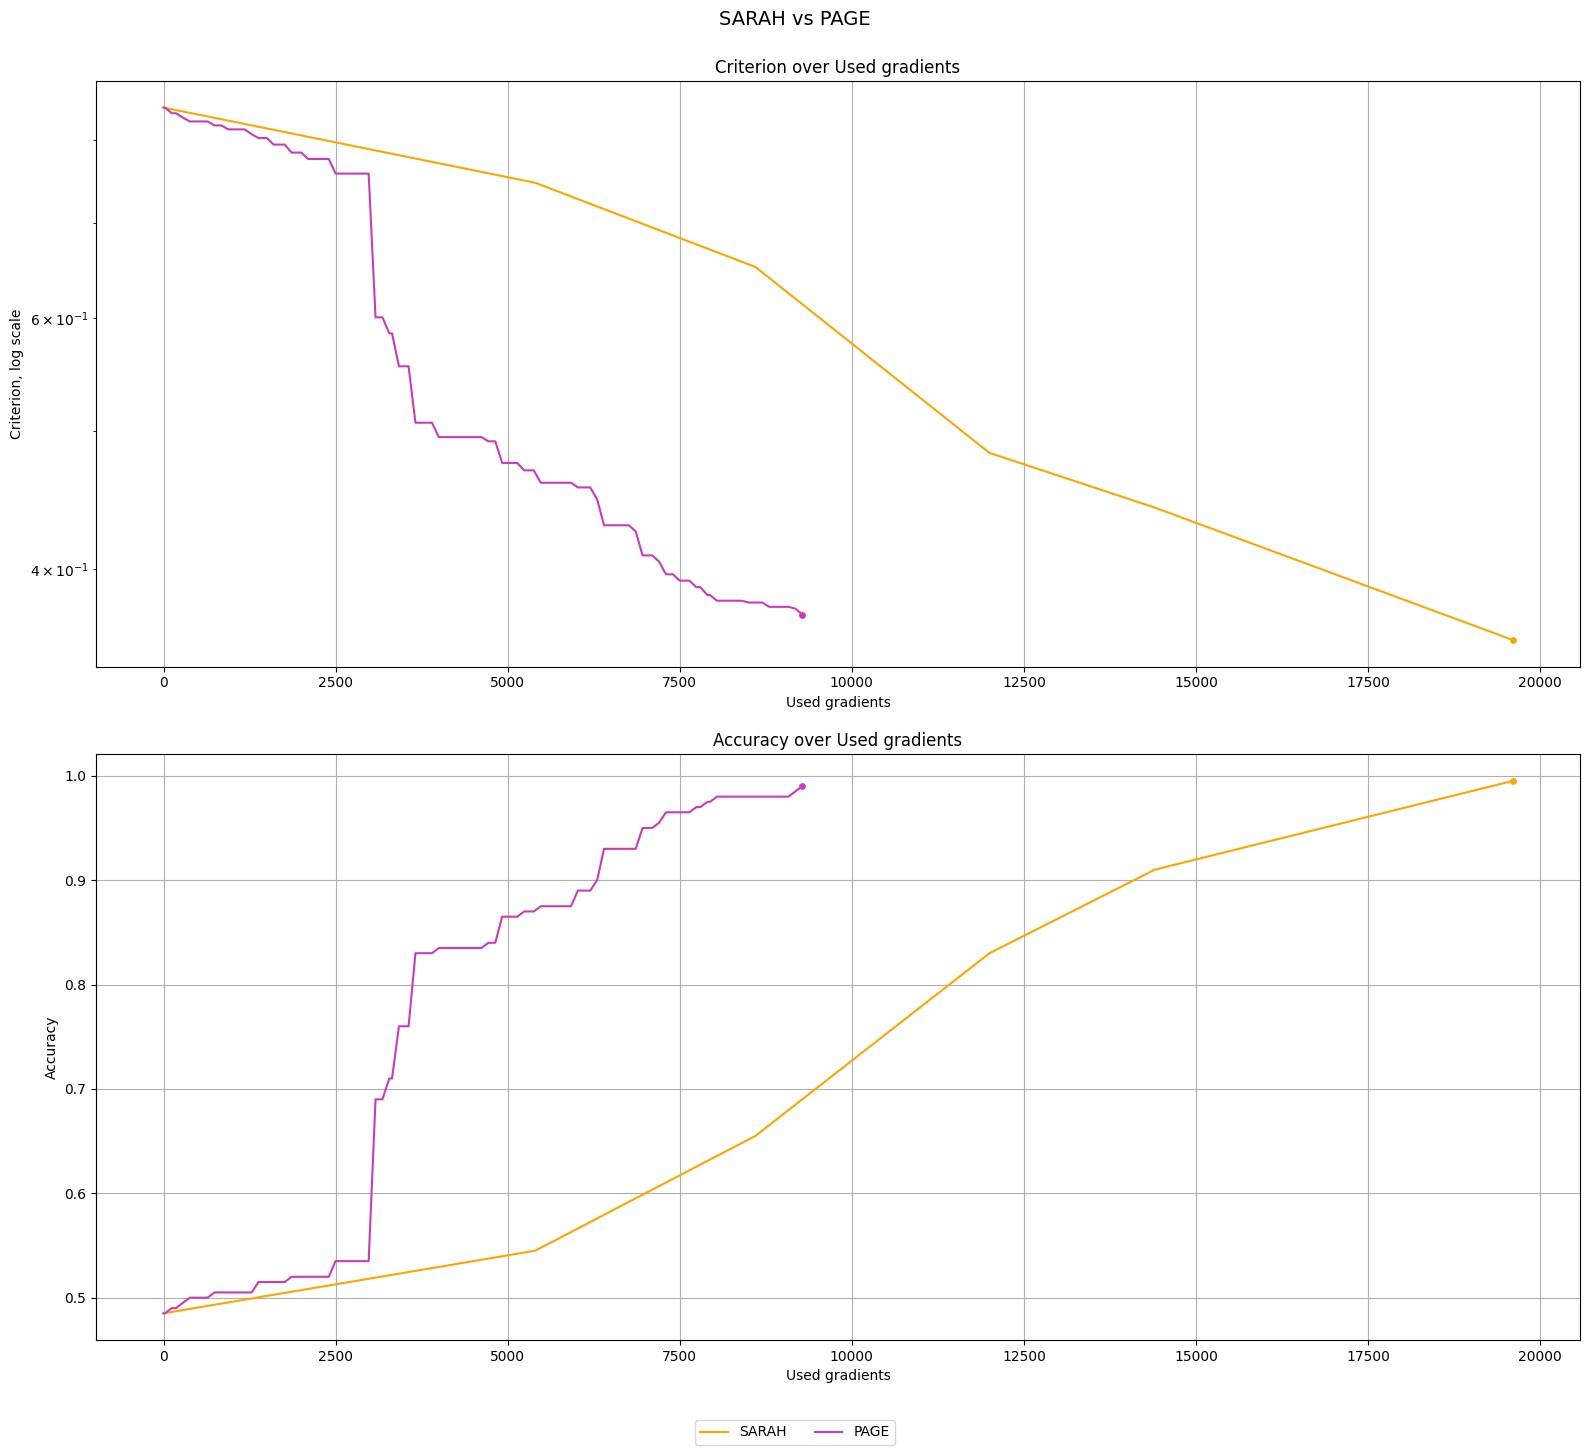

In [850]:
draw_method_plots(
    sarahs,
    plots=[("used_gradients", "criterion"), ("used_gradients", "accuracy")],
    title="SARAH vs PAGE",
)